In [6]:
import h5py    
import numpy as np    

with h5py.File('./datas/milano.h5', 'r') as hdf:
    ls = list(hdf.keys())
    print("list of the dataset", ls)
    idx = hdf.get('idx')
    idx_arr = np.array(idx)
    print("shape of the idx data", idx_arr.shape)
    cell = hdf.get('cell')
    cell_arr = np.array(cell)
    print("shape of the cell data", cell_arr.shape)
    lat = hdf.get('lat')
    lat_arr = np.array(lat)
    print("shape of the lat data", lat_arr.shape)
    lng = hdf.get('lng')
    lng_arr = np.array(lng)
    print("shape of the lng data", lng_arr.shape)
    net = hdf.get('net')
    net_arr = np.array(net)
    print("shape of the net data", net_arr.shape)
    call = hdf.get('call')
    call_arr = np.array(call)
    print("shape of the call data", call_arr.shape)
    sms = hdf.get('sms')
    sms_arr = np.array(sms)
    print("shape of the sms data", sms_arr.shape)
    k_net_att = list(lng.attrs.keys())
    v_net_att = list(lng.attrs.values())

list of the dataset ['call', 'cell', 'idx', 'lat', 'lng', 'net', 'sms']
shape of the idx data (1344, 1)
shape of the cell data (9953,)
shape of the lat data (9953,)
shape of the lng data (9953,)
shape of the net data (1344, 10000)
shape of the call data (1344, 10000)
shape of the sms data (1344, 10000)


In [7]:
print([i[0] for i in idx_arr])


[1383523200, 1383526800, 1383530400, 1383534000, 1383537600, 1383541200, 1383544800, 1383548400, 1383552000, 1383555600, 1383559200, 1383562800, 1383566400, 1383570000, 1383573600, 1383577200, 1383580800, 1383584400, 1383588000, 1383591600, 1383595200, 1383598800, 1383602400, 1383606000, 1383609600, 1383613200, 1383616800, 1383620400, 1383624000, 1383627600, 1383631200, 1383634800, 1383638400, 1383642000, 1383645600, 1383649200, 1383652800, 1383656400, 1383660000, 1383663600, 1383667200, 1383670800, 1383674400, 1383678000, 1383681600, 1383685200, 1383688800, 1383692400, 1383696000, 1383699600, 1383703200, 1383706800, 1383710400, 1383714000, 1383717600, 1383721200, 1383724800, 1383728400, 1383732000, 1383735600, 1383739200, 1383742800, 1383746400, 1383750000, 1383753600, 1383757200, 1383760800, 1383764400, 1383768000, 1383771600, 1383775200, 1383778800, 1383782400, 1383786000, 1383789600, 1383793200, 1383796800, 1383800400, 1383804000, 1383807600, 1383811200, 1383814800, 1383818400, 138

# Premiere approche
Une première approche sera d'observer l'evolution du trafic en considerant la zone dans sa globalité, en faisant la moyenne des valeurs de toutes les zones pour chaque instant.


1344


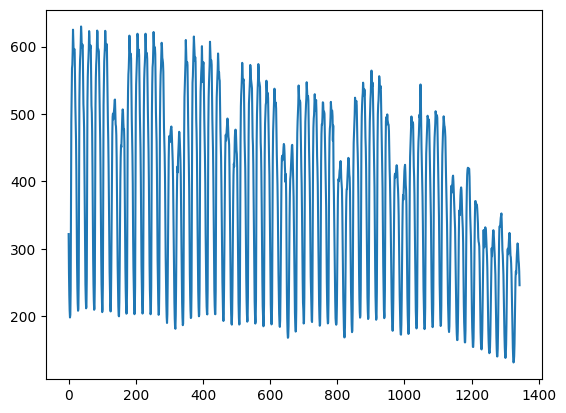

In [8]:
from matplotlib import pyplot as plt 

net_mean = [np.mean(data) for data in net_arr]
print(len(net_mean))
plt.plot(net_mean)

plt.show()


On peut aussi faire correspondre les valeurs jour par jour.

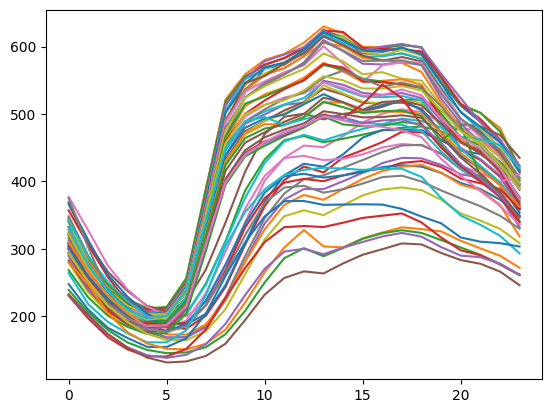

In [9]:
net_mean_days = np.array_split(net_mean, len(net_mean)/24)

for day in net_mean_days:
    plt.plot(day)

On observe un pattern dans l'évolution du trafic au court de la journée.
Il y a aussi des variations dans l'intensité de ce pattern.
Il serait intéressant de voir ce qui peut influencer l'intensité de ces variations.

# Observation de la répartition spaciale du trafic

Notre objectif sera de visualiser l'important du trafic par rapport au zone géographique à un instant donnée.

In [10]:
print(net_arr[0][0])
print(len(net_arr))
print(len(net_arr[0]))

50.342
1344
10000


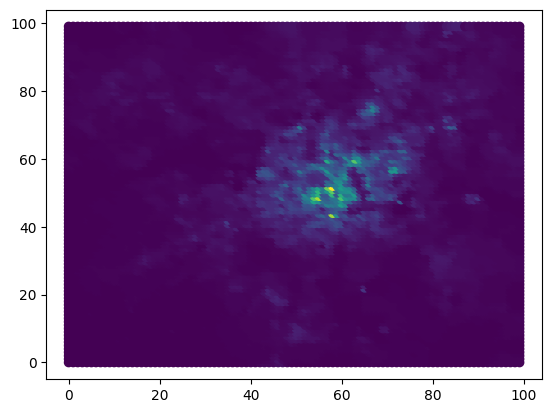

In [11]:
def plot_time(time: int):
    x = []
    y = []
    colors = []

    for i in range (100):
        for j in range(100):
            x.append(j)
            y.append(i)
            colors.append(net_arr[time][i*100 + j])

    plt.scatter(x, y, c=colors)
    plt.show()

plot_time(10)

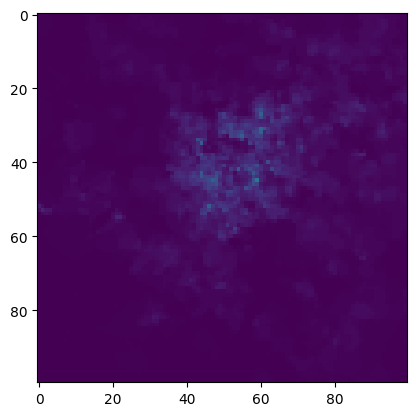

In [12]:
import matplotlib as mpl
import matplotlib.animation as animation
import datetime

fig, ax = plt.subplots()

norm = mpl.colors.Normalize(vmin=np.amin(net_arr), vmax=(np.amax(net_arr)*0.4))

def f(x, y, t):
    res = []
    for i in x:
        temp = []
        for j in y:
            temp.append(net_arr[t][j*100 + i])
        res.append(temp)
    return res

x = [i for i in range (99, -1, -1)]
y = [i for i in range (100)]

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(48):
# for i in range(len(net_arr)):
    im = ax.imshow(f(x, y, i), animated=True, norm=norm)
    if i == 0:
        ax.imshow(f(x, y, i), norm=norm)  # show an initial one first

    date = datetime.datetime.fromtimestamp(idx_arr[i][0])
    date_str = date.strftime('%Y-%m-%d %H:%M')
    ims.append([im, plt.text(-1, -1, f'date: {date_str}')])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=1000)


plt.show()

from IPython.display import HTML
HTML(ani.to_jshtml())

On peut observer dans le temps l'évolution du trafic réseau.

Sur les deux premiers jours, on observe que celui-ci est majoritairement concentré sur une zone de milan et que la majeure partie de trafic se situe entre 12h et 18h.
On observe un pic vers 14h.

# Correlation spacial (pearson)

In [13]:
from numpy import transpose
from scipy.stats import pearsonr

inv_net_arr = transpose(net_arr)
print(inv_net_arr)

corr_idx = 550


[[ 50.342  46.15   35.053 ...  75.675  73.45   70.867]
 [ 50.432  46.158  35.018 ...  76.026  73.874  71.184]
 [ 50.528  46.167  34.98  ...  76.401  74.324  71.521]
 ...
 [155.437 129.599 129.524 ... 320.175 290.035 227.054]
 [ 88.086  69.681  71.3   ... 146.527 147.479 124.444]
 [ 75.428  61.007  59.194 ... 104.689  86.59   72.738]]


In [14]:
corr, _ = pearsonr(inv_net_arr[corr_idx], inv_net_arr[corr_idx + 1])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.996


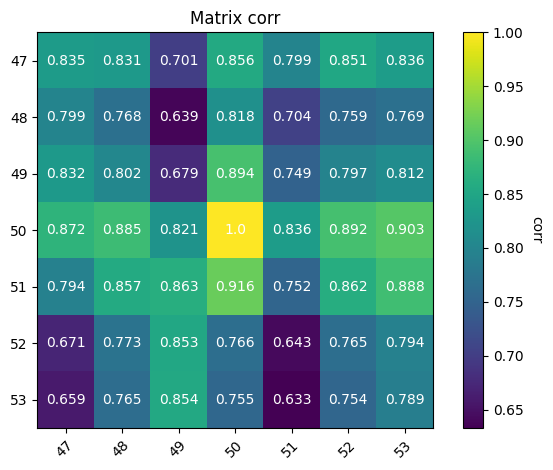

In [15]:
def get_corr_matrix(idx, dist):
    matrix_corr = []
    for x in range (-dist, dist + 1):
        temp = []
        for y in range(-dist, dist + 1):
            corr, _ = pearsonr(inv_net_arr[idx + x], inv_net_arr[idx + 100*y])
            temp.append(corr)
        matrix_corr.append(temp)
    return matrix_corr

def plot_corr_matrix(idx, dist):
    x_pos = [idx % 100 + x for x in range (-dist, dist + 1)]
    y_pos = [int(idx/100) + x for x in range (-dist, dist + 1)]

    harvest = get_corr_matrix(idx, dist)


    fig, ax = plt.subplots()
    im = ax.imshow(harvest)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(x_pos)), labels=x_pos)
    ax.set_yticks(np.arange(len(y_pos)), labels=y_pos)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(y_pos)):
        for j in range(len(x_pos)):
            text = ax.text(j, i, round(harvest[i][j], 3),
                        ha="center", va="center", color="w")

    ax.set_title("Matrix corr")
    fig.tight_layout()

    # Color of plot as legend
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("corr", rotation=-90, va="bottom")
    

    plt.show()

plot_corr_matrix(5050, 3)

# Auto correlation

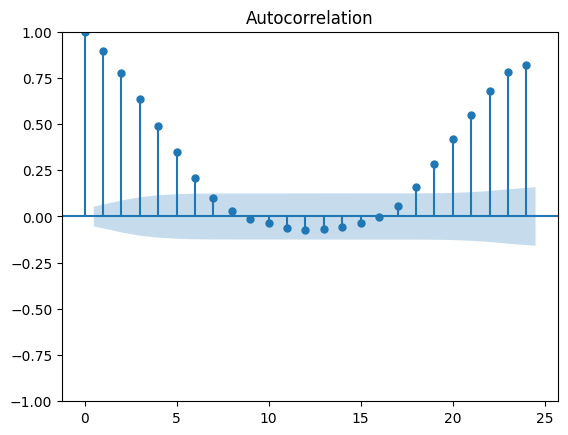

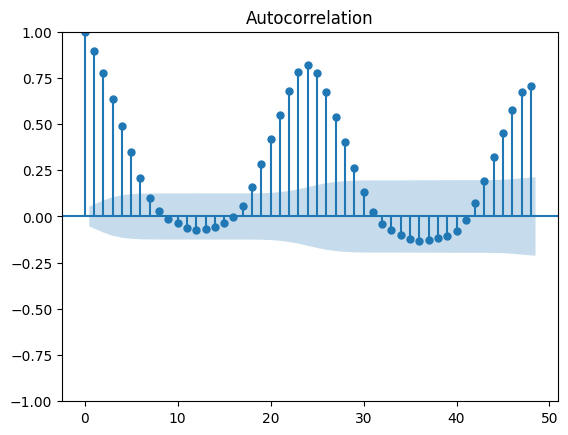

In [36]:
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(inv_net_arr[5050], lags=24)
plt.show()

L'auto correlation semble indiquer que le trafic suis une forme sinusoidale. 
